## **ML Part**

In [6]:
import matplotlib.pyplot as plt
import numpy as np 

import torchvision.models as models
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch 
import timeit

import math
from math import pi
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt


from tqdm.auto import tqdm
import itertools
import random
import time
import os
import pandas as pd
from torchmetrics import R2Score

torch.manual_seed(44)

In [7]:


class Dataset(Dataset):

    # Constructor
    def __init__(self,params,transform=None):

        if len(params['DATA_PATH'])!=0:
          self.df = self.transform_df(params['DATA_PATH'],params['SEQUENCE_LENGTH'])
        
        else:
          self.df = params['DF']

        if  params['SNR'] !=-1:
          df = pd.DataFrame(columns=self.df.columns)
          for snr in params['SNR']:
            temp = self.df.loc[self.df['all_snr'] == snr]
            df = temp.append(df)

          self.df = df



        self.sequence_length = params['SEQUENCE_LENGTH']
        self.inputs = self.df[['all_snr','all_y_SD']].values
        self.inputs = np.clip(self.df['all_y_SD'].values, -np.sqrt(R), np.sqrt(R)).astype(float)
        #self.inputs = self.inputs/np.std(self.inputs)
        try:
          self.labels = self.df['all_MAP'].values.astype(float)
        except:
          self.labels = np.zeros_like(self.inputs)
          
        self.len = len(self.inputs)//self.sequence_length


    # Get the length
    def __len__(self):
        return self.len 
    
    # Getter
    def __getitem__(self, index):

          input = torch.tensor(self.inputs[index * self.sequence_length : (index+1)*self.sequence_length]).type(torch.Tensor).view(self.sequence_length)
          label = torch.tensor(self.labels[index * self.sequence_length : (index+1)*self.sequence_length]).type(torch.Tensor)
          return input,label

    def split_data(self):
      val_size = params['VALIDATION_AND_TEST_SET_SIZE']
      return torch.utils.data.random_split(self,[self.len - 2 *int(self.len*val_size),  int(self.len*val_size),  int(self.len*val_size)])

    def transform_df(self,path,seq_len):
      df = pd.read_csv(path)
      #for i in range(1,seq_len):
      #  df['y_SD-'+str(i)] = df['y_SD'].shift(i)
      #df = df[seq_len:]
      #df.reset_index(drop=True, inplace=True)
      return df


We create three dataset objects, one for the training, one for the validation and on for testing.

In [8]:


class Experiment:
 
    def __init__(self,model=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.use_cuda = torch.cuda.is_available()
        self.model = model.to(self.device)
        self.optimizer = None
        self.scheduler = None
        self.criterion = torch.nn.MSELoss().to(self.device)#L1Loss(reduction='sum').cuda() if self.use_cuda else torch.nn.L1Loss(reduction='sum')
        self.train_losses = []
        self.val_losses = []
        self.start_epoch = 1
        self.val_R2_scores = []

    def train(self,train_data_loader,
              val_data_loader,
              save_dir,
              model_name,
              num_epochs=75, 
              batch_size=64, 
              learning_rate=0.001,
              validate_each_epoch=False,
              verbose=False):
       
        #self.train_losses = []
        #self.val_losses = []
 
        self.model.train()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=4, verbose=True)
        pbar = tqdm(range(self.start_epoch, num_epochs + 1))
        self.r2score = R2Score().to(self.device)

        for epoch in pbar:
 
            #print('Epoch {}/{} '.format(epoch, num_epochs),end =" ")
 
            epoch_losses = []
            i = 0
            for i, data in enumerate(train_data_loader, 1):
 
                noisy_signals, denoised_signals = data
                noisy_signals = noisy_signals.to(self.device)
                
                denoised_signals =denoised_signals.to(self.device)
                source =noisy_signals.view(-1, 32, 1)


                target_out = denoised_signals.view(-1, 32, 1)

                self.optimizer.zero_grad()

                #start = timeit.default_timer()

                y_hat = self.model((source, source))

                #stop = timeit.default_timer()
                #ExecutionTimeCalculation.append(stop - start)  
                #print("iter", i,"  Avg exec Time ", stop - start,'  loss ',np.mean(epoch_losses))

                y_hat = y_hat.view(-1)
                y = target_out.view(-1)


                #print('Time: ', stop - start)  
                
                loss = self.criterion(y_hat, y)
                loss.backward()
 
                self.optimizer.step()
    
            
                epoch_losses.append(loss.data.cpu())
                #if verbose:
                  #pbar.set_postfix({'Batch loss ': loss.data.cpu(),"  Total loss ":np.mean(epoch_losses)})
 
                self.start_epoch = epoch
                
            self.train_losses.append(np.mean(epoch_losses))
 
 
 
            if validate_each_epoch:
                val_loss,val_R2_score= self.test(val_data_loader)
                self.val_losses.append(val_loss)
                self.val_R2_scores.append(val_R2_score)
                if verbose:
                  pbar.set_postfix({"  Train loss ":np.mean(epoch_losses),' Val loss ':val_loss,' Val R2 ':val_R2_score})
                  #print('validation loss : {}'.format((val_loss)))

            #Lr scheduler64
            self.scheduler.step(np.mean(epoch_losses))
            


    def predict(self,data_loader):
        """Tests the network.
 
        """
        
        self.model.eval()
        
        predictions = []

        with torch.no_grad():
            for data in data_loader:
                noisy_signals, denoised_signals = data
                noisy_signals = noisy_signals.to(self.device)
                denoised_signals = denoised_signals.to(self.device)
                #denoised_signals = bpsk_to_bit(denoised_signals).to(self.device)
 

                source =noisy_signals.view(-1, 32, 1)
                
                y_hat = self.model((source, source))

                y_hat = y_hat.view(-1)
                predictions.extend(list(y_hat.cpu().numpy()))
 
        self.model.train()
        return predictions

    def test(self,data_loader, batch_size=64):
        """Tests the network.
 
        """
        
        self.model.eval()
        
        epoch_losses = []
        epoch_R2_scores = []

        with torch.no_grad():
            for data in data_loader:
                noisy_signals, denoised_signals = data
                noisy_signals = noisy_signals.to(self.device)
                denoised_signals = denoised_signals.to(self.device)
                #denoised_signals = bpsk_to_bit(denoised_signals).to(self.device)
                source =noisy_signals.view(-1, 32, 1)
                target_out = denoised_signals.view(-1, 32, 1)
                
                y_hat = self.model((source, source))

                y_hat = y_hat.view(-1)
                y = target_out.view(-1)
                
                loss = self.criterion(y_hat, y)
                epoch_losses.append(loss.data.cpu().numpy())
                epoch_R2_scores.append(self.r2score(y_hat, y).cpu().numpy())

        self.model.train()
        return np.mean(epoch_losses), np.mean(epoch_R2_scores)
 
    def save_parameters(self,model_name, directory):
        """Saves the parameters of the network to the specified directory.
 
        Parameters
        ----------
        epoch : int
            The current epoch
        directory : str
            The directory to which the parameters will be saved
        """
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save({
            'epoch': self.start_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, os.path.join(directory, model_name +'.pth'))
 
    def load_parameters(self, path):
        """Loads the given set of parameters.
 
        Parameters
        ----------
        path : str
            The file path pointing to the file containing the parameters
        """
        self.optimizer = torch.optim.Adam(self.model.parameters())
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.start_epoch = checkpoint['epoch']
 
 



In [9]:

 
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.nn import Linear


def smape_loss(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()


def gen_trg_mask(length, device):
    mask = torch.tril(torch.ones(length, length, device=device)) == 1

    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )

    return mask


class BNET_TRANSFORMER(pl.LightningModule):
    def __init__(
        self,
        n_encoder_inputs,
        n_decoder_inputs,
        channels=64,
        num_embeddings=256,
        dropout=0.1,
        lr=1e-3,
        num_heads = 1,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.lr = lr
        self.dropout = dropout

        self.input_pos_embedding = torch.nn.Embedding(num_embeddings, embedding_dim=channels)
        self.target_pos_embedding = torch.nn.Embedding(num_embeddings, embedding_dim=channels)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=channels,
            nhead=num_heads,
            dropout=self.dropout,
            dim_feedforward=4 * channels,
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=channels,
            nhead=num_heads,
            dropout=self.dropout,
            dim_feedforward=4 * channels,
        )

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=8)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=8)

        self.input_projection = Linear(n_encoder_inputs, channels)
        self.output_projection = Linear(n_decoder_inputs, channels) 

        self.linear = Linear(channels, 1)

        self.do = nn.Dropout(p=self.dropout)

        self.fc2_prob_symbol_0  =  nn.Linear(32*channels, 32)
        self.fc2_prob_symbol_1  =  nn.Linear(32*channels, 32)


    def encode_src(self, src):
        src_start = self.input_projection(src).permute(1, 0, 2)

        in_sequence_len, batch_size = src_start.size(0), src_start.size(1)
        pos_encoder = (
            torch.arange(0, in_sequence_len, device=src.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )

        pos_encoder = self.input_pos_embedding(pos_encoder).permute(1, 0, 2)

        src = src_start + pos_encoder

        src = self.encoder(src) + src_start

        return src

    def decode_trg(self, trg, memory):

        trg_start = self.output_projection(trg).permute(1, 0, 2)

        out_sequence_len, batch_size = trg_start.size(0), trg_start.size(1)

        pos_decoder = (
            torch.arange(0, out_sequence_len, device=trg.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )
        pos_decoder = self.target_pos_embedding(pos_decoder).permute(1, 0, 2)

        trg = pos_decoder + trg_start

        trg_mask = gen_trg_mask(out_sequence_len, trg.device)

        out = self.decoder(tgt=trg, memory=memory, tgt_mask=trg_mask) + trg_start

        out = out.permute(1, 0, 2)

       # out = self.linear(out)

        return out

    def forward(self, x):
        src, trg = x

        src = self.encode_src(src)

        out = self.decode_trg(trg=trg, memory=src)

        x = out.reshape((out.shape[0],-1))
        prob_symbol_0 = torch.sigmoid(self.fc2_prob_symbol_0(x))
        prob_symbol_1 = torch.sigmoid(self.fc2_prob_symbol_1(x))

        LLR = torch.log(prob_symbol_0/prob_symbol_1) 

        return LLR 




if __name__ == "__main__":

    source = torch.rand(size=(128, 32, 1))
    target_in = torch.rand(size=(128, 32, 1))
    target_out = torch.rand(size=(128, 32, 1))

    ts = BNET_TRANSFORMER(n_encoder_inputs=1, n_decoder_inputs=1)

    pred = ts((source, target_in))

    print(pred.size())

    ts.training_step((source, target_in, target_out), batch_idx=1)





torch.Size([128, 32])


/home/hazem/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:652: UserWarning: `training_step` must be implemented to be used with the Lightning Trainer
  rank_zero_warn("`training_step` must be implemented to be used with the Lightning Trainer")


In [10]:
params = {}
params['SEQUENCE_LENGTH'] = 32# or 64 or 128
params['SNR']   = -1#[3]#[5.5,6][1,1.5,2,2.5,3]#

R     = 50
GAMMA = 100
Tc = 32
P_B = 0.5


ExecutionTimeCalculation = []


params['DATA_PATH'] = "train datasets/Tc = "+str(Tc)+", pb = " +str(P_B)+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ".csv"
#params['DATA_PATH'] = "train datasets/COMBINED pb = 0.3.csv"
params['VALIDATION_AND_TEST_SET_SIZE'] = 0.1

dataset =Dataset(params)
train_dataset ,val_dataset, test_dataset  = dataset.split_data()
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 128)
validation_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=512)

model  = BNET_TRANSFORMER(n_encoder_inputs=1,
                          n_decoder_inputs=1,
                          channels=32,
                          num_embeddings=128,
                          dropout=0.1,
                          num_heads = 1)

exp = Experiment(model)

for param in exp.model.parameters():
    param.requires_grad = True


In [6]:
exp.train(train_data_loader=train_loader,
          val_data_loader=validation_loader,
          save_dir="",
          model_name = '',
          num_epochs= 300,
          learning_rate=0.001, 
          validate_each_epoch=True,
          verbose=True)

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:

PATH = "BNET + TRANSFORMER"

exp.save_parameters(PATH,'./models R50 G100/')


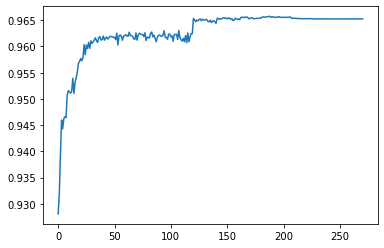

In [90]:
plt.plot(exp.val_R2_scores)

In [12]:
MSE = 0.5


PATH = "BNET + Transformer, seq_len = "+str(params['SEQUENCE_LENGTH'])+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", MSE = "+str(MSE)

exp.save_parameters(PATH,'./')

In [ ]:
##Export to matlab
"""
import torch.utils.model_zoo as model_zoo
import torch.onnx
# set the model to inference mode
torch_model = exp.model
torch_model.eval()

# Input to the model
x = torch.randn(64800//32, 32, requires_grad=True)
torch_out = torch_model(x)
# Export the model
torch.onnx.export(torch_model, # model being run
                    x, # model input (or a tuple for multiple inputs)
                    "bnet.onnx", # where to save the model (can be a file or file-like object)
                    export_params=True, # store the trained parameter weights inside the model file
                    opset_version=9, # the ONNX version to export the model to
                    do_constant_folding=True, # whether to execute constant folding for optimization
                    input_names = ['input'], # the model's input names
                    output_names = ['output'], # the model's output names
                    dynamic_axes={'input' : {0 : 'batch_size'}, # variable length axes
                    'output' : {0 : 'batch_size'}})"""

'\nimport torch.utils.model_zoo as model_zoo\nimport torch.onnx\n# set the model to inference mode\ntorch_model = exp.model\ntorch_model.eval()\n\n# Input to the model\nx = torch.randn(64800//32, 32, requires_grad=True)\ntorch_out = torch_model(x)\n# Export the model\ntorch.onnx.export(torch_model, # model being run\n                    x, # model input (or a tuple for multiple inputs)\n                    "bnet.onnx", # where to save the model (can be a file or file-like object)\n                    export_params=True, # store the trained parameter weights inside the model file\n                    opset_version=9, # the ONNX version to export the model to\n                    do_constant_folding=True, # whether to execute constant folding for optimization\n                    input_names = [\'input\'], # the model\'s input names\n                    output_names = [\'output\'], # the model\'s output names\n                    dynamic_axes={\'input\' : {0 : \'batch_size\'}, # variable

In [12]:
exp.load_parameters("models R50 G100/BNET + TRANSFORMER.pth")

R     = 50
GAMMA = 100
P_B = 0.1
backbone_string = " + TRANSFORMER"

MSE = "0.7"
params = {}
params['SEQUENCE_LENGTH'] = 32

FOLDER = "test datasets/G"+str(GAMMA)+"_R"+str(R)+'/'

test = pd.DataFrame(columns=['snr','R','gamma','p_B', 'MAP_BCJR', 'Received', 'MAP_BNET'])
snr_db  = [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6]#,7,8,9,10]
snr_db  = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8]
snr_db  = [4,4.5,5,5.5,6]

for snr in tqdm(snr_db):
                params['SNR']   = [snr]
                params['DATA_PATH'] = ''
                df = pd.read_csv(FOLDER+str(snr)+"received.csv")
                params['DF'] = df
                dataset_test =Dataset(params)

                test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=512)
                MAP_hat = exp.predict(test_loader)

                temp_df =pd.DataFrame(columns=['snr', 'MAP_BCJR', 'Received', 'MAP_BNET'])
                temp_df['snr'] = [snr for i in range(len(MAP_hat))]
                temp_df['MAP_BCJR'] = dataset_test.df['all_MAP'].values.copy()
                temp_df['Received'] = dataset_test.df['all_y_SD'].values.copy()
                temp_df['MAP_BNET'] = MAP_hat
                del dataset_test
                temp_df.round(3).to_csv(FOLDER+str(snr)+" predictions BNET"+backbone_string+".csv",index=False)
                del temp_df
                del df
                import gc
                gc.collect()

#test.to_csv("test datasets/predictions BNET"+backbone_string+", seq_len = "+str(params['SEQUENCE_LENGTH'])+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", p_B = "+str(P_B)+".csv",index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_65445/3713487102.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp.append(df)
/tmp/ipykernel_65445/3713487102.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp.append(df)
/tmp/ipykernel_65445/3713487102.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp.append(df)
/tmp/ipykernel_65445/3713487102.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp.append(df)
/tmp/ipykernel_65445/3713487102.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp.append(df)


## Plot BER and MSE

In [11]:

from scipy.special import erfc #erfc/Q function
from random import choices
import numpy as np
from math import pi
import scipy.signal as signal
import math
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
 
def plot_BERs(path_BNET, others):

      results_BNET =  pd.read_csv(path_BNET)
      results_others = []
      for path in others:
        try:
          results_others.append(pd.read_csv(path))
        except:
          break

      markers = ["s","H","o","*","v","X","<",">","1","2","3","4","8","s","p","P","*","h",".","x","o","v","H","<",">","1","2","3","4","8","s","p","P","*","h"]
      colors = ['b','g', 'm','c','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k']
      fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(10,10))
      j = 0

      for column in results_BNET.columns:
        EbN0dBs = results_BNET['snr_s'].values
        BER = results_BNET[column].values
        if column == 'BER_BCJRs':
          label = "BCJR"
        elif column == 'BER_BNETs':
          label = "BNET"
        elif column == 'BER_Nothing_s':
          label = "Nothing"
        elif column in ['snr_s', 'BER_Nothing_s'] :
          continue
        else:
          label = column
        
        BER = BER[BER >  9.10e-6]
        ax.semilogy(EbN0dBs[:len(BER)],BER,color= colors[j],marker=markers[j],linestyle='solid',label=label,markersize=15)
        j+=1

      for id in range(len(results_others)): 

        for column in results_others[id].columns:
          BER =  results_others[id][column].values[:len(BER)]
          #EbN0dBs = results_BNET_GRU['snr_s'].values
          if column == 'BER_BNETs':
            labels = ["BNET with GRU","BNET with LSTM","BNET with RNN"]
            label = labels[id]
          elif column in ['BER_BCJRs','snr_s', 'BER_Nothing_s'] :
            continue
          else:
            label = column
          BER = BER[BER > 9.10e-6]
          ax.semilogy(EbN0dBs[:len(BER)],BER,color= colors[j],marker=markers[j],linestyle='solid',label=label,markersize=15)
          j+=1


        
        #BER = BER[BER !=0]

        
      ax.set_xlabel('$E_b/N_0(dB)$',fontsize=25)
      ax.set_ylabel('BER ($P_b$)',fontsize=25)
      ax.set_title('Probability of Bit Error for BPSK over TSMG channel with LDPC',fontsize=15)
      ax.grid(True)
      ax.legend(fontsize=22)
      plt.xticks(size = 18)
      plt.yticks(size = 25)
      plt.show()

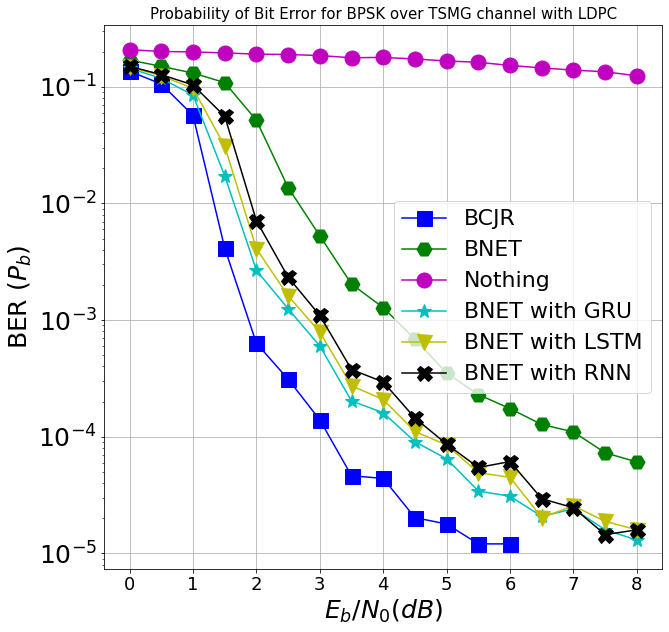

In [ ]:

R     = 100
GAMMA = 100
P_B = 0.1
PATH_BNET = 'results/BNET, gamma = '+str(GAMMA)+', R = '+str(R)+', p_B = '+str(P_B)+'.csv'
PATH_BNET_GRU = 'results/BNET + GRU, gamma = '+str(GAMMA)+', R = '+str(R)+', p_B = '+str(P_B)+'.csv'
PATH_BNET_LSTM = 'results/BNET + LSTM, gamma = '+str(GAMMA)+', R = '+str(R)+', p_B = '+str(P_B)+'.csv'
PATH_BNET_RNN = 'results/BNET + RNN, gamma = '+str(GAMMA)+', R = '+str(R)+', p_B = '+str(P_B)+'.csv'

plot_BERs(PATH_BNET,[PATH_BNET_GRU,PATH_BNET_LSTM,PATH_BNET_RNN])

In [ ]:

from scipy.special import erfc #erfc/Q function
from random import choices
import numpy as np
from math import pi
import scipy.signal as signal
import math
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
 
def plot_BERs(path_BNET):

      results_BNET =  pd.read_csv(path_BNET)


      markers = ["s","H","o","*","v","X","<",">","1","2","3","4","8","s","p","P","*","h",".","x","o","v","H","<",">","1","2","3","4","8","s","p","P","*","h"]
      colors = ['b','g', 'm','c','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k']
      fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(10,10))
      j = 0

      for column in results_BNET.columns:
        EbN0dBs = results_BNET['snr_db'].values
        BER = results_BNET[column].values
        if column == 'BER_BCJRs':
          label = "BCJR"
        elif column == 'BER_BNETs':
          label = "BNET"
        elif column == 'BER_Nothing_s':
          label = "Nothing"
        elif column in ['snr_db', 'BER_Nothing_s'] :
          continue
        else:
          label = column
        
        BER = BER[BER >  9.10e-6]
        ax.semilogy(EbN0dBs[:len(BER)],BER,color= colors[j],marker=markers[j],linestyle='solid',label=label,markersize=15)
        j+=1


        
        #BER = BER[BER !=0]

        
      ax.set_xlabel('$E_b/N_0(dB)$',fontsize=25)
      ax.set_ylabel('BER ($P_b$)',fontsize=25)
      ax.set_title('Probability of Bit Error for BPSK over TSMG channel with LDPC',fontsize=15)
      ax.grid(True)
      ax.legend(fontsize=22)
      plt.xticks(size = 18)
      plt.yticks(size = 25)
      plt.show()

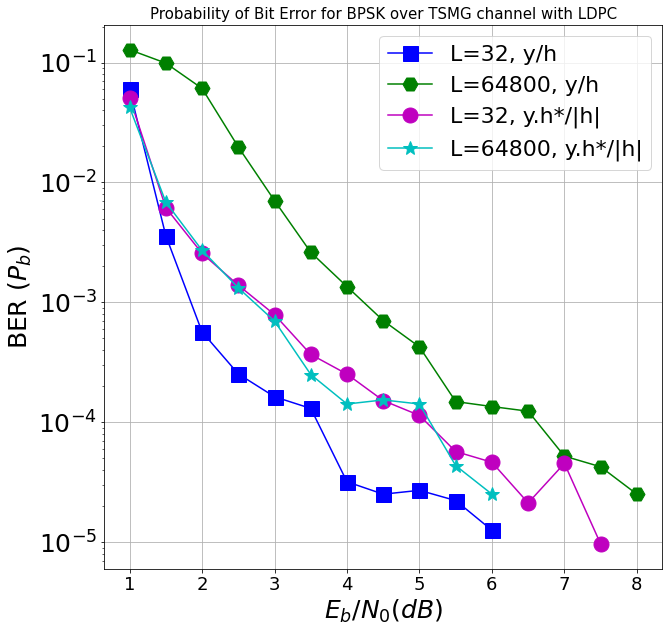

In [ ]:


PATH_BNET = '/home/hazem/Desktop/BNET/comparing_equalization_&_L_size_R100_G100.csv'

plot_BERs(PATH_BNET)

In [ ]:

from scipy.special import erfc #erfc/Q function
from random import choices
import numpy as np
from math import pi
import scipy.signal as signal
import math
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.metrics import mean_squared_error
 
def plot_MSEs(path_BNET, path_BNET_GRU,PATH_BNET_LSTM = -1):

      BNET_df =  pd.read_csv(path_BNET)
      BNET_GRU_df =  pd.read_csv(path_BNET_GRU)
      if  PATH_BNET_LSTM != -1 :
        BNET_GRU_LSTM_df =  pd.read_csv(PATH_BNET_LSTM)

      EbN0dBs = BNET_df['snr']
      BNET_df['prediction MSE'] = BNET_df['MAP_BCJR'] -  BNET_df['MAP_BNET']
      BNET_MSE_dB = BNET_df.groupby(['snr'])['prediction MSE'].agg(lambda x: 10*np.log10(np.sum(x * x)/(len(BNET_df)/len(BNET_df.snr.value_counts()))))
      del BNET_df
      
      BNET_GRU_df['prediction MSE'] = BNET_GRU_df['MAP_BCJR'] -  BNET_GRU_df['MAP_BNET']
      BNET_GRU_MSE_dB = BNET_GRU_df.groupby(['snr'])['prediction MSE'].agg(lambda x: 10*np.log10(np.sum(x * x)/(len(BNET_GRU_df)/len(BNET_GRU_df.snr.value_counts()))))

      del BNET_GRU_df

      markers = ["o","x","*","v","H","<",">","1","2","3","4","8","s","p","P","*","h",".","x","o","v","H","<",">","1","2","3","4","8","s","p","P","*","h"]
      colors = ['b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k']
      
      fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(10,10))
      

      ax.plot(EbN0dBs.drop_duplicates().values,BNET_MSE_dB.values,color= colors[0],marker=markers[0],linestyle='solid',label='BNET')
      ax.plot(EbN0dBs.drop_duplicates().values,BNET_GRU_MSE_dB.values,color= colors[1],marker=markers[1],linestyle='solid',label='BNET with GRU')
      if  PATH_BNET_LSTM != -1 :

        BNET_GRU_LSTM_df['prediction MSE'] = BNET_GRU_LSTM_df['MAP_BCJR'] -  BNET_GRU_LSTM_df['MAP_BNET']
        BNET_GRU_LSTM_MSE_dB = BNET_GRU_LSTM_df.groupby(['snr'])['prediction MSE'].agg(lambda x: 10*np.log10(np.sum(x * x)/(len(BNET_GRU_LSTM_df)/len(BNET_GRU_LSTM_df.snr.value_counts()))))
        del BNET_GRU_LSTM_df
        ax.plot(EbN0dBs.drop_duplicates().values,BNET_GRU_LSTM_MSE_dB.values,color= colors[2],marker=markers[2],linestyle='solid',label='BNET with LSTM and Attention')

        #BER = BER[BER !=0]

        
      ax.set_xlabel('$E_b/N_0(dB)$',fontsize=25)
      ax.set_ylabel('MSE (dB)',fontsize=25)
      ax.set_title('MSE performance for different SNR values',fontsize=15)
      ax.grid(True)
      ax.legend(fontsize=22)
      plt.xticks(size = 25)
      plt.yticks(size = 25)
      plt.show()

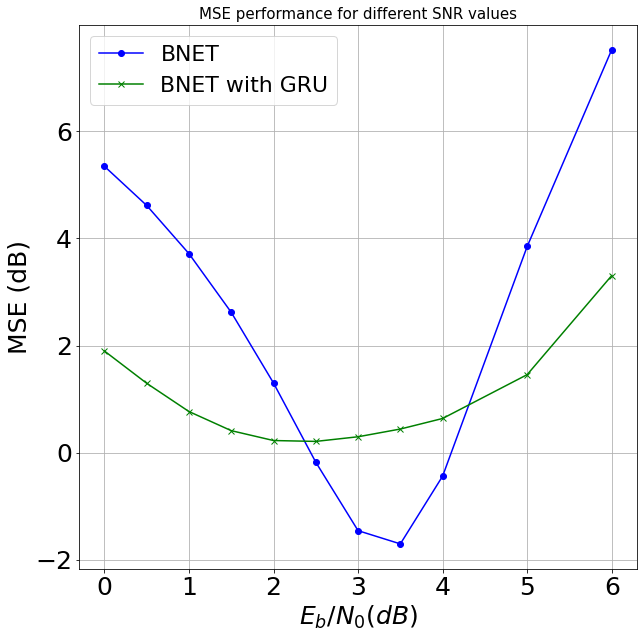

In [ ]:

R     = 100
GAMMA = 20
P_B = 0.1
SEQUENCE_LENGTH = 32
SEQUENCE_LENGTH_GRU = 32

PATH_BNET ="test datasets/predictions BNET, seq_len = "+str(SEQUENCE_LENGTH)+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", p_B = "+str(P_B)+".csv"
PATH_BNET_GRU = "test datasets/predictions BNET + GRU, seq_len = "+str(SEQUENCE_LENGTH_GRU)+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", p_B = "+str(P_B)+".csv"
PATH_BNET_LSTM = "test datasets/predictions BNET + LSTM + Attention, seq_len = "+str(SEQUENCE_LENGTH_GRU)+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", p_B = "+str(P_B)+".csv"

if not os.path.exists(PATH_BNET_LSTM) :
    PATH_BNET_LSTM = -1

plot_MSEs(PATH_BNET,PATH_BNET_GRU,PATH_BNET_LSTM)


## obtain MSE = f (Gamma,R)

In [ ]:
params = {}
params['SEQUENCE_LENGTH'] = 32# or 64 or 128
R_list  = [1,10,20,30,40,50,60,70,80,90,100]


for R in R_list :

    GAMMA     = 20
    P_B = 0.5
    print('R = ',R)
    params = {}
    params['SEQUENCE_LENGTH'] = 32# or 64 or 128
    params['SNR'] = [0,1,2,3,4,5,6,7,8,9,10]
    params['DATA_PATH'] = "train datasets/varying R/pb = " +str(P_B)+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ".csv"
    params['VALIDATION_AND_TEST_SET_SIZE'] = 0.1

    dataset =Dataset(params)
    train_dataset ,val_dataset, test_dataset  = dataset.split_data()
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 128)
    validation_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=1024)
    for USE_GRU in [False,True]:

        model = BNET(seq_len = params['SEQUENCE_LENGTH'],GRU = USE_GRU)
        exp = Experiment(model)

        for param in exp.model.parameters():
            param.requires_grad = True

        exp.train(train_data_loader=train_loader,
                val_data_loader=validation_loader,
                save_dir="",
                model_name = '',
                num_epochs=150,
                learning_rate=0.001, 
                validate_each_epoch=True,
                verbose=True)

params = {}
params['SEQUENCE_LENGTH'] = 32# or 64 or 128
SNR_list  = [1,1.5,2,2.5,3,3.5,4,5,6]#[5.5,6]

R     = 100
GAMMA = 100
P_B = 0.5

df = pd.read_csv("/test datasets/pb = " +str(0.1)+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ".csv")

for snr in SNR_list :
    params['SNR'] = [snr]
    params['DATA_PATH'] = "train datasets/pb = " +str(P_B)+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ".csv"
    params['VALIDATION_AND_TEST_SET_SIZE'] = 0.1

    dataset =Dataset(params)
    train_dataset ,val_dataset, test_dataset  = dataset.split_data()
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 128)
    validation_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=1024)
    for USE_GRU in [False,True]:

        model = BNET(seq_len = params['SEQUENCE_LENGTH'],GRU = USE_GRU)
        exp = Experiment(model)

        for param in exp.model.parameters():
            param.requires_grad = True

        exp.train(train_data_loader=train_loader,
                val_data_loader=validation_loader,
                save_dir="",
                model_name = '',
                num_epochs=250,
                learning_rate=0.001, 
                validate_each_epoch=True,
                verbose=True)

        if USE_GRU:
            PATH = "G100_R100/BNET + GRU, seq_len = "+str(params['SEQUENCE_LENGTH'])+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", SNR = "+str(params['SNR'][0] )
        else:
            PATH = "G100_R100/BNET, seq_len = "+str(params['SEQUENCE_LENGTH'])+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", SNR = "+str(params['SNR'][0] )

        exp.save_parameters(PATH,'models')
        

        params['SNR']   = [snr]
        params['DATA_PATH'] = ''
        params['DF'] = df
        dataset_test =Dataset(params)
        test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=4096)
        MAP_hat = exp.predict(test_loader)

        temp_df =pd.DataFrame(columns=['snr', 'MAP_BCJR', 'Received', 'MAP_BNET'])
        temp_df['snr'] = [snr for i in range(len(MAP_hat))]
        #temp_df['R'] = [R for i in range(len(MAP_hat))]
        #temp_df['gamma'] = [R for i in range(len(MAP_hat))]
        #temp_df['p_B'] = [P_B for i in range(len(MAP_hat))]
        temp_df['MAP_BCJR'] = dataset_test.df['all_MAP'].values.copy()
        temp_df['Received'] = dataset_test.df['all_y_SD'].values.copy()
        temp_df['MAP_BNET'] = MAP_hat
        #test = test.append(temp_df.round(3))
        del dataset_test

        gru_string = ""
        if USE_GRU:
            gru_string = " + GRU"
        temp_df.round(3).to_csv("test datasets/G50_R20/"+str(snr)+" predictions BNET"+gru_string+", seq_len = "+str(params['SEQUENCE_LENGTH'])+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", p_B = "+str(0.1)+".csv",index=False)
        del temp_df
        import gc
        gc.collect()

#test.to_csv("test datasets/predictions BNET"+gru_string+", seq_len = "+str(params['SEQUENCE_LENGTH'])+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", p_B = "+str(P_B)+".csv",index=False)

583

In [ ]:
exp.model

BNET(
  (fc1): Sequential(
    (0): Linear(in_features=32, out_features=160, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2_prob_symbol_0): Linear(in_features=160, out_features=32, bias=True)
  (fc2_prob_symbol_1): Linear(in_features=160, out_features=32, bias=True)
)

## BCJR MAP algorithm

In [ ]:
p_B = 0.1
R = 20
gamma = 1
snr_db = 10

lin_SNR=10**(snr_db/10)
trans_signal_power = 1
noise_power_input=trans_signal_power/lin_SNR
sigma_A=noise_power_input
sigma_B=noise_power_input*(R)

p_G=1-p_B
p_BG=(1/gamma)*p_G
p_GB=(1/gamma)*p_B
p_BB=1-p_BG

init_state_prob=np.array([p_G, p_B])
modulation_alphabet=np.array([1 ,-1])
mod_alphabet_apriori=np.array([.5, .5])

trans_mat=np.array([[1-p_GB, p_GB],
                     [p_BG, 1-p_BG]])
GaussPDFmean=np.array([0, 0])
GaussPDFvariance=np.array([sigma_A, sigma_B])


def MAPdecoding_TSMGaussianNoise_Real_BPSK(y,modulation_alphabet,mod_alphabet_apriori,
                                        trans_mat,init_state_prob,GaussPDFmean,GaussPDFvariance):

# [1] "Power Line Commucations" (p. 277-278) Ferreira, Lampe et al., Wiley 2010

# [2] "Channel Coding in Communication Networks. From Theory to Turbocodes", A. Glavieux et al., ISTE 2007
    
    N=len(trans_mat)# number of states
    L=len(y)
    M=len(modulation_alphabet)

    symbols_proba=np.zeros((M,L))


# Reshaping

    init_state_prob     = init_state_prob.reshape((N))

    GaussPDFmean        = GaussPDFmean.reshape((N))

    GaussPDFvariance    =GaussPDFvariance.reshape((N))

    modulation_alphabet =modulation_alphabet.reshape((M))

    mod_alphabet_apriori=mod_alphabet_apriori.reshape((M))

# Forward-backward filters initialization

    alpha=np.zeros((N,L))
    alpha[:,0] = init_state_prob

    beta=np.zeros((N,L+1)) # only beta(:,2:L+1) elements are used in the algo
    beta[:,-1]=1

    # initial alpha and beta normalization in order to avoid recursive computation imprecisions [2]
    #alpha[:,0]= alpha[:,0]/np.sum(alpha[:,0])
   ##beta[:,-1]=beta[:,-1]/np.sum(beta[:,-1])
    #end normalization 


# Forward-backward filters recursive computation

    temp_ones=np.ones((M))

    temp_GaussPDFvariance=np.kron(GaussPDFvariance,temp_ones)

    temp_GaussPDFmean=np.kron(GaussPDFmean,temp_ones)

    temp_modulation_alphabet= np.tile(modulation_alphabet,(1,N)) #  # see if necessary
    temp_mod_alphabet_apriori= np.tile(mod_alphabet_apriori,(1,N)) # python

    temp_previous_alpha=np.kron(alpha[:,0],temp_ones)
    next_beta = beta[:,-1]


    for k in range(L-1):

        exponent = np.power(y[k]-temp_modulation_alphabet-temp_GaussPDFmean,2) / (2*temp_GaussPDFvariance+0.0000001)
        p_nk_alpha=(1/np.sqrt(2*np.pi*temp_GaussPDFvariance+0.0000001))*np.exp(-exponent)
        for  s in range(N):
        
            # Forward filter: alpha
            
            # Computation of F_k 
        
            # noise probability given each state and for each symbol,

            # Remark: The first M elements of p_nk_alpha correspond to the noise probability p_nk(n_k=y_k-c_k|s_k=s1) for each symbol c_k given the first state of the Markov chain 
            
            ps_alpha=trans_mat[:,s]# p(s_k+1|s_k) for each state s_k
            temp_ps_alpha=np.kron(ps_alpha,temp_ones)



            F_k_alpha=temp_ps_alpha*p_nk_alpha # the reading of F_k_alpha is similar to p_nk_alpha (see the above remark)

            temp_alpha=F_k_alpha*temp_mod_alphabet_apriori*temp_previous_alpha# SEE IF KRON CAN BE USED TO COMPUTE temp_alpha LIKE FOR THE BACKWARD FILTER
            alpha[s,k+1]=np.sum(temp_alpha)


            # Backward filter: beta. SEE IF INTERESTING TO EXPLICITELY EXPRESS F_k
            exponent = np.power(y[L-1-k]-modulation_alphabet-GaussPDFmean[s],2) / (2*GaussPDFvariance[s]+0.0000001)
            p_nk_beta=(1/np.sqrt(2*np.pi*GaussPDFvariance[s]+0.0000001))*np.exp(-exponent)

            temp1=p_nk_beta*mod_alphabet_apriori
                        
            ps_beta=trans_mat[s,:]# p(s_k+1|s_k) for each state s_k+1
            
            temp2=ps_beta*next_beta;              
            
            temp_beta=np.kron(temp2,temp1)
            
            beta[s,L-1-k]=np.sum(temp_beta)    


        
        # alpha and beta normalization in order to avoid recursive computation imprecisions [2]
        
        #alpha(:,k+1)=alpha(:,k+1)/sum(alpha(:,k+1));
        
        #beta(:,L-k+1)=beta(:,L-k+1)/sum(beta(:,L-k+1));
        
        sum_alpha=np.sum(alpha[:,k+1])
        sum_beta=np.sum(beta[:,L-k-1])
        if sum_alpha==0 :#% situation where alpha(s,k+1)=0 for all states "s" due to numerical imprecisions (mainly from exponential computation in p_nk)
            alpha[:,k+1]=1/N
        else:
            alpha[:,k+1]=alpha[:,k+1]/sum_alpha

            
        if sum_beta==0:
            beta[:,L-k-1]=1/N
        else:
            beta[:,L-k-1]=beta[:,L-k-1]/sum_beta
            
        # end normalization
        temp_previous_alpha=np.kron(alpha[:,k+1],temp_ones)
        next_beta=beta[:,L-k-1]


    for k in range(L):
        alpha_replicate= np.tile(alpha[:,k],(N,1)) 
        beta_replicate= np.tile(beta[:,k+1],(N,1)) 
             
        for m in range(M):

            exponent = np.power(y[k]-modulation_alphabet[m]-GaussPDFmean,2) / (2*GaussPDFvariance+0.0000001)
            p_nk=(1/np.sqrt(2*np.pi*GaussPDFvariance+0.0000001))*np.exp(-exponent)
            p_nk_replicate=np.tile(p_nk,(N,1)) 
                        
            F_k=p_nk_replicate.T*trans_mat

            temp=F_k*alpha_replicate.T*beta_replicate
            symbols_proba[m,k]=mod_alphabet_apriori[m]*sum(sum(temp))# represents p(c_k,y_k), which is proportional to p(c_k|y_k)

            # Note: sum(p(c_k=+/-1,y_k)) is not equal to 1, whereas sum(p(c_k=+/-1|y_k))=1
        
        sum_symb_proba=np.sum(symbols_proba[:,k])
        
        if sum_symb_proba==0 :#% means symbols_proba(:,k) is a null vector. This can arise from numerical imprecision of the exponential computation in p_nk
            
            symbols_proba[:,k]=1/M 
            

    return symbols_proba


Time:  14.168596586001513


In [ ]:

y = np.random.randn(64800)
import timeit
start = timeit.default_timer()
for i in range(64800//32):
    symbols_proba = MAPdecoding_TSMGaussianNoise_Real_BPSK(y[i:i+32],modulation_alphabet,mod_alphabet_apriori,trans_mat,init_state_prob,GaussPDFmean,GaussPDFvariance)
stop = timeit.default_timer()
print('Time: ', stop - start) 

In [ ]:
map =  np.log(symbols_proba[0]/symbols_proba[1])
map.round(3)

array([-4.669, -4.739, -4.664, ...,  4.644,  4.267, -4.772])

In [ ]:
original_map = df.all_MAP[-64800:].values
original_map

array([-4.669, -4.739, -4.664, ...,  4.645,  4.268, -4.772])

## BMMSE for Gaussian Source + TSMG 

In [ ]:
import numpy as np
import pandas as pd
from random import choices
N = 100000
sigma_G_2 = 1
sigma_x_2 = 0.5
R = 100
sigma_B_2 = sigma_G_2 * R
n,states = TSMG(P_B=0.1,
                NOISE_MEMORY = 10,
                SIGMA_G = np.sqrt(sigma_G_2),
                R = R,
                nb_of_symbols = N,
                print_transition_probs = False,
                add_states = True)

x = np.random.randint(0,2,N) 
x = (x-0.5)*2 + np.random.normal(0,np.sqrt(sigma_x_2),N)
y = x + n

data = pd.DataFrame()
data['x'] = x
data['n'] = n
data['y'] = y
data['noise states'] = states



data['x_hat | x = 1, i = G'] = 1 + (data['y'] - 1) * sigma_x_2 / (sigma_G_2 + sigma_x_2)
data['x_hat | x = -1, i = G'] = -1 + (data['y'] + 1) * sigma_x_2 / (sigma_G_2 + sigma_x_2)
data['distance to 1 | i = G'] = np.abs(data['x_hat | x = 1, i = G'] - np.ones_like(x))
data['distance to -1 | i = G'] = np.abs(data['x_hat | x = -1, i = G'] + np.ones_like(x))



data['x_hat | x = -1, i = B'] = -1 + (data['y'] + 1) * sigma_x_2 / (sigma_B_2 + sigma_x_2)
data['x_hat | x = 1, i = B'] = 1 + (data['y'] - 1) * sigma_x_2 / (sigma_B_2 + sigma_x_2)
data['distance to -1 | i = B'] = np.abs(data['x_hat | x = -1, i = B'] + np.ones_like(x))
data['distance to 1 | i = B'] = np.abs(data['x_hat | x = 1, i = B'] - np.ones_like(x))


data['x_hat | i = G'] = (data['distance to 1 | i = G'] < data['distance to -1 | i = G'])
data['x_hat | i = G'] = data['x_hat | i = G'] * data['x_hat | x = 1, i = G'] + (1-data['x_hat | i = G']) * data['x_hat | x = -1, i = G']

data['x_hat | i = B'] = (data['distance to 1 | i = B'] < data['distance to -1 | i = B'])
data['x_hat | i = B'] = data['x_hat | i = B'] * data['x_hat | x = 1, i = B'] + (1-data['x_hat | i = B']) * data['x_hat | x = -1, i = B']

data['x_hat'] = data['noise states'] * data['x_hat | i = B'] + (1-data['noise states']) * data['x_hat | i = G']


data['x_hat_Gaussian_only'] = 2 * y / sigma_G_2 
print('Gaussian MSE dB = ',10 * np.log10(np.mean(np.abs(data['x_hat_Gaussian_only']- data['x']))))
print('original MSE dB = ',10 * np.log10(np.mean(np.abs(y - data['x']))))
print('Estimation MSE dB = ',10 * np.log10(np.mean(np.abs(data['x_hat'] - data['x']))))
print('BER = ',np.mean((data['x_hat'] > 0) !=(data['x']>0)))
print('BER Gaussian estimation = ',np.mean((data['x_hat_Gaussian_only'] > 0) !=(data['x']>0)))
data.head(20)

Gaussian MSE dB =  5.214364577373639
original MSE dB =  1.8514425662535139
Estimation MSE dB =  -1.5474934697274176
BER =  0.21339
BER Gaussian estimation =  0.21339


,x,n,y,noise states,"x_hat | x = 1, i = G","x_hat | x = -1, i = G",distance to 1 | i = G,distance to -1 | i = G,"x_hat | x = -1, i = B","x_hat | x = 1, i = B",distance to -1 | i = B,distance to 1 | i = B,x_hat | i = G,x_hat | i = B,x_hat,x_hat_Gaussian_only
0,2.152475,-2.368095,-0.215620,1,0.594793,-0.738540,0.405207,0.261460,-0.996098,0.993952,0.003902,0.006048,-0.738540,-0.996098,-0.996098,-0.431239
1,0.222049,0.894382,1.116432,0,1.038811,-0.294523,0.038811,0.705477,-0.989470,1.000579,0.010530,0.000579,1.038811,1.000579,1.038811,2.232863
2,-0.420582,0.344190,-0.076391,0,0.641203,-0.692130,0.358797,0.307870,-0.995405,0.994645,0.004595,0.005355,-0.692130,-0.995405,-0.692130,-0.152783
3,0.791943,-0.043572,0.748372,0,0.916124,-0.417209,0.083876,0.582791,-0.991302,0.998748,0.008698,0.001252,0.916124,0.998748,0.916124,1.496743
4,0.793989,0.381049,1.175038,0,1.058346,-0.274987,0.058346,0.725013,-0.989179,1.000871,0.010821,0.000871,1.058346,1.000871,1.058346,2.350076
5,-2.036230,-1.068233,-3.104464,0,-0.368155,-1.701488,1.368155,0.701488,-1.010470,0.979580,0.010470,0.020420,-1.701488,-1.010470,-1.701488,-6.208927
6,-1.614020,-1.402681,-3.016701,0,-0.338900,-1.672234,1.338900,0.672234,-1.010033,0.980016,0.010033,0.019984,-1.672234,-1.010033,-1.672234,-6.033402
7,0.812290,-0.482266,0.330024,0,0.776675,-0.556659,0.223325,0.443341,-0.993383,0.996667,0.006617,0.003333,0.776675,0.996667,0.776675,0.660049
8,1.023866,0.195288,1.219154,0,1.073051,-0.260282,0.073051,0.739718,-0.988959,1.001090,0.011041,0.001090,1.073051,1.001090,1.073051,2.438308
9,1.687643,-0.444427,1.243216,0,1.081072,-0.252261,0.081072,0.747739,-0.988840,1.001210,0.011160,0.001210,1.081072,1.001210,1.081072,2.486432


In [ ]:
import numpy as np
import pandas as pd
from random import choices
N = 64800
sigma_G_2 = 1/10**(0.8)
R = 100
sigma_B_2 = sigma_G_2 * R

n,states = TSMG(P_B=0.1,
                NOISE_MEMORY = 100,
                SIGMA_G = np.sqrt(sigma_G_2),
                R = R,
                nb_of_symbols = N,
                print_transition_probs = False,
                add_states = True)
A = 1
#x = np.random.randint(0,2,N) 
#x = (x-0.5)*2*A 
y = x + n

A = 1
data = pd.DataFrame()
data['x'] = x
data['n'] = n
data['y'] = y
data['noise states'] = states



data['x_hat | x = 1, i = G'] = A + (data['y'] - A) * sigma_x_2 / (sigma_G_2 + sigma_x_2)
data['x_hat | x = 1, i = B'] = A + (data['y'] - A) * sigma_x_2 / (sigma_B_2 + sigma_x_2)
data['x_hat | x = 1'] = data['noise states'] * data['x_hat | x = 1, i = B'] + (1-data['noise states']) * data['x_hat | x = 1, i = G']

data['x_hat | x = -1, i = G'] = -A + (data['y'] + A) * sigma_x_2 / (sigma_G_2 + sigma_x_2)
data['x_hat | x = -1, i = B'] = -A + (data['y'] + A) * sigma_x_2 / (sigma_B_2 + sigma_x_2)
data['x_hat | x = -1'] = data['noise states'] * data['x_hat | x = -1, i = B'] + (1-data['noise states']) * data['x_hat | x = -1, i = G']


data['distance to -1'] = np.abs(data['x_hat | x = -1'] + np.ones_like(x)*A)
data['distance to 1'] = np.abs(data['x_hat | x = 1'] - np.ones_like(x)*A)

data['x_hat'] = (data['distance to 1'] <= data['distance to -1'])
data['x_hat'] = data['x_hat'] * data['x_hat | x = 1'] + (1-data['x_hat']) * data['x_hat | x = -1']

data['x_hat_Gaussian_only'] = 2 * y / sigma_G_2 
#print('Gaussian MSE dB = ',10 * np.log10(np.mean(np.abs(data['x_hat_Gaussian_only']- data['x']))))
#print('original MSE dB = ',10 * np.log10(np.mean(np.abs(y - data['x']))))
#print('Estimation MSE dB = ',10 * np.log10(np.mean(np.abs(data['x_hat'] - data['x']))))
#print('BER = ',np.mean((data['x_hat'] > 0) !=(data['x']>0)))
#print('BER Gaussian estimation = ',np.mean((data['x_hat_Gaussian_only'] > 0) !=(data['x']>0)))
data = data.drop(columns = ['x_hat | x = 1, i = G','x_hat | x = 1, i = B','x_hat | x = -1, i = G','x_hat | x = -1, i = B',],axis = 1)
data.head(20)

,x,n,y,noise states,x_hat | x = 1,x_hat | x = -1,distance to -1,distance to 1,x_hat,x_hat_Gaussian_only
0,-1,-0.626612,-1.626612,1,0.919670,-1.019164,0.019164,0.080330,-1.019164,-20.526458
1,-1,0.600022,-0.399978,1,0.957184,-0.981650,0.018350,0.042816,-0.981650,-5.047385
2,1,-3.682257,-2.682257,1,0.887385,-1.051449,0.051449,0.112615,-1.051449,-33.847798
3,-1,-0.265365,-1.265365,1,0.930718,-1.008116,0.008116,0.069282,-1.008116,-15.967823
4,1,2.385433,3.385433,1,1.072954,-0.865880,0.134120,0.072954,1.072954,42.721271
5,1,0.895119,1.895119,1,1.027375,-0.911458,0.088542,0.027375,1.027375,23.914788
6,1,1.902831,2.902831,1,1.058194,-0.880640,0.119360,0.058194,1.058194,36.631252
7,-1,-2.318016,-3.318016,1,0.867942,-1.070892,0.070892,0.132058,-1.070892,-41.870529
8,1,0.611994,1.611994,1,1.018717,-0.920117,0.079883,0.018717,1.018717,20.341983
9,-1,6.840931,5.840931,1,1.148050,-0.790784,0.209216,0.148050,1.148050,73.707566


In [ ]:
data['x_hat'].to_csv('x_hat')

In [ ]:
x = pd.read_csv('/home/hazem/Desktop/BNET/8received.csv')['all_y_SD'].values

In [ ]:
x 

array([-1, -1,  1, ..., -1,  1,  1])

In [ ]:


def TSMG(P_B,NOISE_MEMORY,SIGMA_G,R,nb_of_symbols,print_transition_probs = False,add_states = False):

    # list to contain ther_AWGN noise signal :
    Amplitudes = [] 

    #Initial state :
    states = ['B','G']
    initial_probs = [1 , 0]
    previous_state = choices(states,initial_probs)[0]

    #computing the transition probabilities :
    P_GB = P_B / NOISE_MEMORY
    P_BG = 1 / NOISE_MEMORY - P_GB
    if print_transition_probs :
      print('transition from G to B :',P_GB)
      print('transition from B to G :',P_BG)

    # 
    states_list = []

    # Repeting Process for each symbol :
    for i in range(nb_of_symbols): 

      #Getting the current transition probabilities :
      if previous_state == 'G':
        transition_probs = [P_GB , 1-P_GB]
        
      elif previous_state == 'B':

        transition_probs = [1-P_BG , P_BG]

      ## getting the state based on the current state and the transition probabilities
      state = choices(states,transition_probs)[0]
      SIGMA = SIGMA_G
      if state == 'B':
        SIGMA = np.sqrt(R)*SIGMA_G
        previous_state = 'B'
        states_list.append(1)

      else:
        previous_state = 'G'
        states_list.append(0)

      Amplitudes.append(np.random.normal(0,SIGMA,1))
  
    states_list = np.array(states_list).reshape(nb_of_symbols)
    if print_transition_probs :
        print("number of bad_states : ",np.sum(states_list))
    if add_states == False:
      states_list = []
    return np.array(Amplitudes).reshape(nb_of_symbols),np.array(states_list)

In [ ]:
df = pd.read_csv('/home/hazem/Desktop/BNET/test datasets/pb = 0.1, gamma = 100, R = 100.csv')


In [ ]:
df.head()

,all_snr,all_y_SD,all_MAP
0,0.0,-2.759,-5.322
1,0.0,2.684,5.279
2,0.0,-1.549,-3.097
3,0.0,-0.804,-1.608
4,0.0,-0.657,-1.315


<AxesSubplot:>

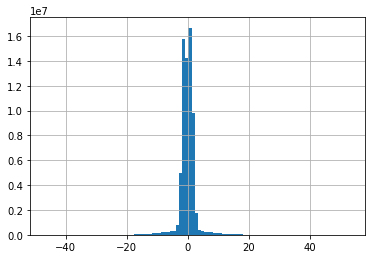

In [ ]:
df.all_y_SD.hist(bins = 100)

In [ ]:
import numpy as np
from hmmlearn import hmm
P_B = 0.5
GAMMA = 10
P_GB = P_B/GAMMA
P_BG = 1 / GAMMA - P_GB

model = hmm.GaussianHMM(n_components=4, covariance_type="full")
model.startprob_ = np.array([(1-P_B)/2,(1-P_B)/2,P_B/2,P_B/2])
model.transmat_ = np.array([[(1-P_GB)/2,(1-P_GB)/2,P_GB/2,P_GB/2],
                            [(1-P_GB)/2,(1-P_GB)/2,P_GB/2,P_GB/2],
                            [(1-P_BG)/2,(1-P_BG)/2,P_BG/2,P_BG/2 ],
                            [(1-P_BG)/2,(1-P_BG)/2,P_BG/2,P_BG/2 ]])
model.means_ = np.array([[1], [-1],[1], [-1]])
model.covars_ = np.array([[[1.]],
                         [[1.]],
                         [[20.]],
                         [[20.]]])
X, Z = model.sample(100000)
print(Z[:10])
print(X[:10])

[3 1 0 0 0 1 1 0 1 0]
[[-7.59988157]
 [-2.46466415]
 [ 1.36185371]
 [ 2.20762311]
 [ 1.94696233]
 [-0.73923681]
 [-0.5636241 ]
 [ 0.54624886]
 [-1.39881752]
 [ 1.08298869]]


In [ ]:
#remodel = hmm.GaussianHMM(n_components=4, covariance_type="full", n_iter=100)
#remodel.fit(X)
Z2 = remodel.predict(X)

In [ ]:
sum(Z2 == Z1)/len(Z)

0.69557

In [ ]:
Z2 = (Z2 == 0).astype(int) + (Z2 == 1).astype(int)
Z1 = (Z == 0).astype(int) + (Z == 1).astype(int)
Z1

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
import numpy as np
import random 
random.seed(0)

players = ['Abid','Abid_friend_CSS','Abid_friend_EST','Abid_friend_KIFNA_KIFOU','Chihab','Fares','Ghassen','Ghazi','Hazem','Khamkhom' ]
team_A = []
for i in range(5):
    player = random.choices(players)[0]
    team_A.append(player)
    players.remove(player)

print('Team A : ',team_A)
print('Team B : ',players)

Team A :  ['Hazem', 'Ghassen', 'Abid_friend_KIFNA_KIFOU', 'Abid_friend_CSS', 'Fares']
Team B :  ['Abid', 'Abid_friend_EST', 'Chihab', 'Ghazi', 'Khamkhom']


In [ ]:
random.choices(['tachkila 1', 'tachkila 2'])[0]

'tachkila 1'